<a href="https://colab.research.google.com/github/AbhiJeet70/Poison_Planetoid/blob/main/Poison_Planetoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached torch_geometric-2.5.3-py3-none-any.whl.metadata (64 kB)
Using cached torch_geometric-2.5.3-py3-none-any.whl (1.1 MB)
Processing dataset: Cora


Processing...
Done!


Statistics for Cora:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Class distribution: [351 217 418 818 426 298 180]
Early stopping at epoch 179
Early stopping at epoch 182
Early stopping at epoch 137
Early stopping at epoch 132
Early stopping at epoch 210
Early stopping at epoch 239
Early stopping at epoch 102
Early stopping at epoch 164
Early stopping at epoch 164
Early stopping at epoch 123
Early stopping at epoch 121
Early stopping at epoch 204
Early stopping at epoch 190
Early stopping at epoch 391
Early stopping at epoch 101
Early stopping at epoch 163
Early stopping at epoch 148
Early stopping at epoch 114
Early stopping at epoch 122
Early stopping at epoch 188
Early stopping at epoch 178
Early stopping at epoch 345
Early stopping at epoch 350
Early stopping at epoch 128
Early stopping at epoch 134
Early stopping at epoch 122
Early stopping at epoch 126
Early stopping at epoch 160
Early stopping at epoch 158
Early stopping a

/tmp/ipykernel_34/2469550401.py:235: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Early stopping at epoch 478
Early stopping at epoch 412
Early stopping at epoch 486
Early stopping at epoch 456
Early stopping at epoch 458
Early stopping at epoch 424


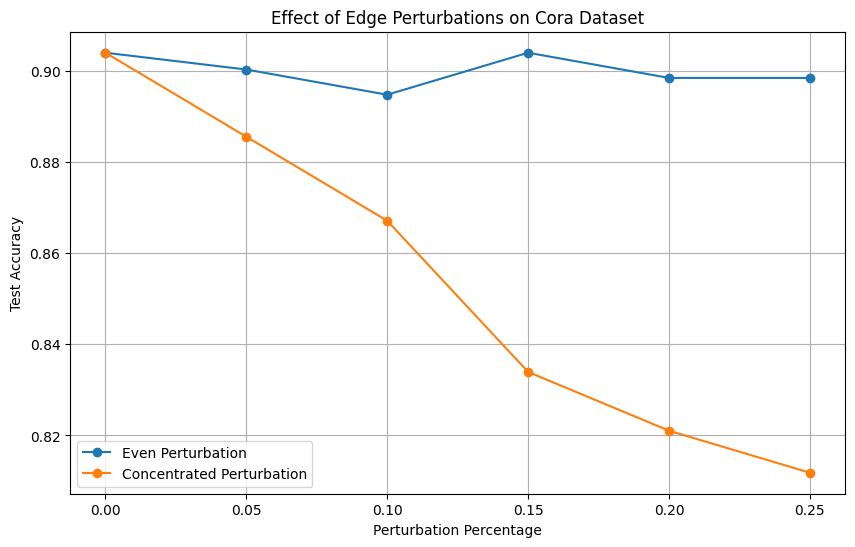

Processing dataset: Pubmed


Processing...
Done!


Statistics for Pubmed:
  Number of nodes: 19717
  Number of edges: 88648
  Number of features: 500
  Number of classes: 3
  Class distribution: [4103 7739 7875]
Early stopping at epoch 272
Early stopping at epoch 369
Early stopping at epoch 499
Early stopping at epoch 306
Early stopping at epoch 264
Early stopping at epoch 393
Early stopping at epoch 201
Early stopping at epoch 266
Early stopping at epoch 389
Early stopping at epoch 382
Early stopping at epoch 188
Early stopping at epoch 204
Early stopping at epoch 476
Best accuracy for Pubmed: 0.8869 with params (64, 0.01, 0.0001)
Early stopping at epoch 341
Early stopping at epoch 427
Early stopping at epoch 321
Early stopping at epoch 391
Early stopping at epoch 240
Early stopping at epoch 345


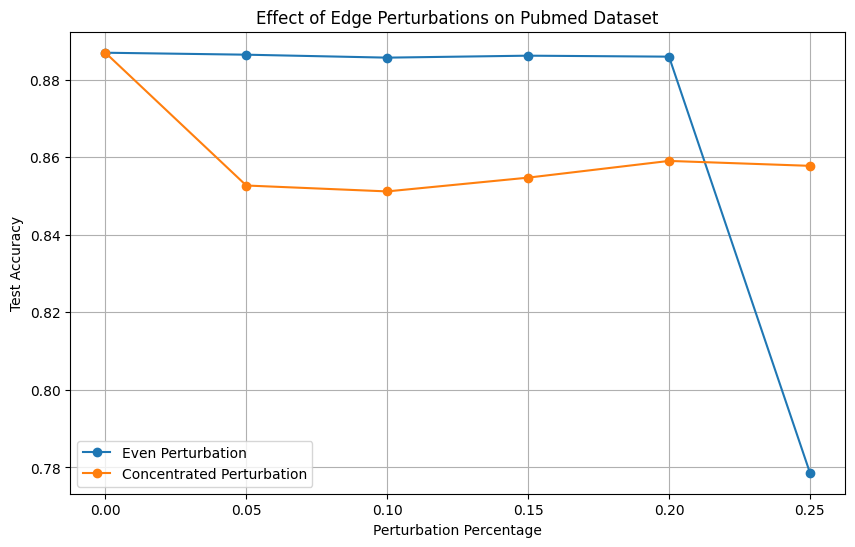

Processing dataset: CiteSeer


Processing...
Done!


Statistics for CiteSeer:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6
  Class distribution: [264 590 668 701 596 508]
Early stopping at epoch 162
Early stopping at epoch 157
Early stopping at epoch 119
Early stopping at epoch 118
Early stopping at epoch 196
Early stopping at epoch 194
Early stopping at epoch 346
Early stopping at epoch 350
Early stopping at epoch 140
Early stopping at epoch 147
Early stopping at epoch 111
Early stopping at epoch 121
Early stopping at epoch 172
Early stopping at epoch 173
Early stopping at epoch 380
Early stopping at epoch 385
Early stopping at epoch 131
Early stopping at epoch 135
Early stopping at epoch 110
Early stopping at epoch 110
Early stopping at epoch 148
Early stopping at epoch 148
Early stopping at epoch 302
Early stopping at epoch 307
Early stopping at epoch 498
Early stopping at epoch 297
Early stopping at epoch 123
Early stopping at epoch 128
Early stopping at epoch 113
Early stopping at

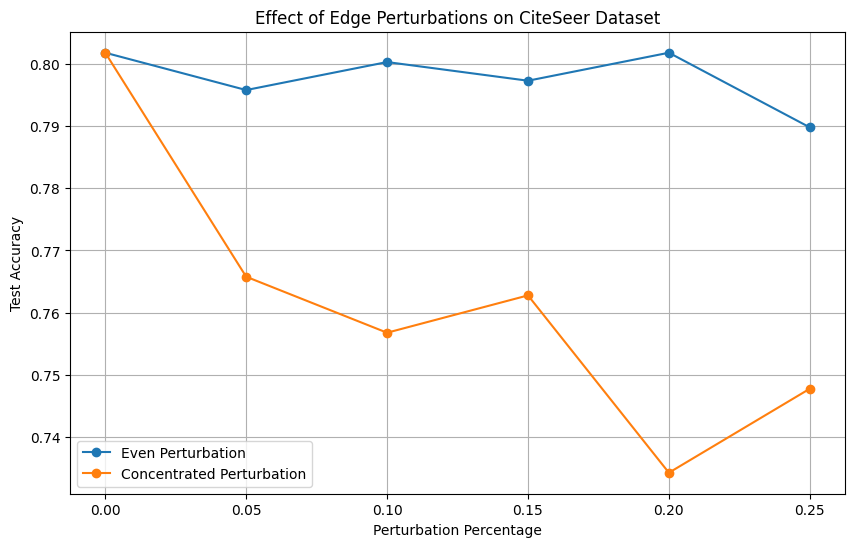

In [ ]:
!pip install torch torch_geometric

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(20)

# Define function to load Planetoid data for a given dataset name
def load_planetoid_data(dataset_name):
    dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=NormalizeFeatures())
    data = dataset[0]
    return data

# Split data into train, validation, and test sets (if needed)
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    train_idx = torch.tensor(indices[:train_end], dtype=torch.long)
    val_idx = torch.tensor(indices[train_end:val_end], dtype=torch.long)
    test_idx = torch.tensor(indices[val_end:], dtype=torch.long)
    return train_idx, val_idx, test_idx

# Define the GCN model with 2 layers
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train and evaluate the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    acc = correct / pyg_data.test_mask.sum().item()
    return acc

# Print dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

# Find nodes with the most and fewest degrees
def find_extreme_degree_nodes(edge_index, num_nodes, top_k=20):
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long))

    top_k_nodes = torch.topk(degrees, top_k).indices
    bottom_k_nodes = torch.topk(degrees, top_k, largest=False).indices
    top_k_degrees = degrees[top_k_nodes]
    bottom_k_degrees = degrees[bottom_k_nodes]

    return top_k_nodes, top_k_degrees, bottom_k_nodes, bottom_k_degrees

def evenly_perturb_edges(data, perturbation_percentage, ascending=False):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_perturbations = int(num_edges * perturbation_percentage)
    total_perturbations = 0

    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))
    sorted_nodes = torch.argsort(degrees)

    if not ascending:
        sorted_nodes = sorted_nodes.flip(dims=[0])

    perturbations_per_node = num_perturbations // data.num_nodes

    for node in sorted_nodes:
        if total_perturbations >= num_perturbations:
            break
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        num_node_edges = connected_edges.sum().item()
        num_perturb_node_edges = min(perturbations_per_node, num_node_edges)

        if num_perturb_node_edges > 0:
            perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
            perturb_edges_idx = perturb_edges_idx[torch.randperm(perturb_edges_idx.size(0))[:num_perturb_node_edges]]
            edge_index[:, perturb_edges_idx] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)
            total_perturbations += num_perturb_node_edges

    data.edge_index = edge_index
    return data

def concentrated_perturb_edges(data, perturbation_percentage, top_k=20):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_perturbations = int(num_edges * perturbation_percentage)
    total_perturbations = 0

    degrees = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))
    sorted_nodes = torch.argsort(degrees, descending=True)

    top_k_nodes = sorted_nodes[:top_k]

    for node in top_k_nodes:
        if total_perturbations >= num_perturbations:
            break
        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)
        num_perturb_node_edges = min(len(perturb_edges_idx), num_perturbations - total_perturbations)

        if num_perturb_node_edges > 0:
            perturb_edges_idx = perturb_edges_idx[torch.randperm(len(perturb_edges_idx))[:num_perturb_node_edges]]
            edge_index[:, perturb_edges_idx] = torch.randint(0, data.num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)
            total_perturbations += num_perturb_node_edges

    data.edge_index = edge_index
    return data, top_k_nodes

# Hyperparameter grid search
hidden_channels_list = [64, 128, 256, 512]
learning_rates = [0.01, 0.05, 0.005, 0.001, 0.0005]
weight_decays = [1e-4, 1e-5]

# List of datasets to process
datasets = ['Cora', 'Pubmed', 'CiteSeer']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Dataset', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Process each dataset and print accuracies
for dataset_name in datasets:
    print(f'Processing dataset: {dataset_name}')
    data = load_planetoid_data(dataset_name)

    # Print dataset statistics
    print_dataset_statistics(data, dataset_name)

    # Prepare the masks
    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    best_acc = 0
    best_params = None

    # Grid search for best hyperparameters
    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for weight_decay in weight_decays:
                model = GCNNet(data.num_node_features, hidden_channels, data.y.max().item() + 1)
                acc = train_model(model, data, lr, weight_decay)
                if acc > best_acc:
                    best_acc = acc
                    best_params = (hidden_channels, lr, weight_decay)

    print(f"Best accuracy for {dataset_name}: {best_acc:.4f} with params {best_params}")

    # Add best model accuracy to the results DataFrame
    new_row = {
        'Dataset': dataset_name,
        'Hidden_Channels': best_params[0],
        'Learning_Rate': best_params[1],
        'Weight_Decay': best_params[2],
        'Accuracy': best_acc,
        'Perturbation_Type': 'None',
        'Perturbation_Percentage': 0
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Perturbation experiments
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
    perturbation_results = {"Even": [], "Concentrated": []}

    for perturbation_percentage in perturbation_percentages:
        # Even perturbation
        perturbed_data = evenly_perturb_edges(data.clone(), perturbation_percentage)
        model = GCNNet(data.num_node_features, best_params[0], data.y.max().item() + 1)
        even_acc = train_model(model, perturbed_data, best_params[1], best_params[2])
        perturbation_results["Even"].append(even_acc)

        new_row = {
            'Dataset': dataset_name,
            'Hidden_Channels': best_params[0],
            'Learning_Rate': best_params[1],
            'Weight_Decay': best_params[2],
            'Accuracy': even_acc,
            'Perturbation_Type': 'Even',
            'Perturbation_Percentage': perturbation_percentage
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Concentrated perturbation
        perturbed_data, top_k_nodes = concentrated_perturb_edges(data.clone(), perturbation_percentage)
        model = GCNNet(data.num_node_features, best_params[0], data.y.max().item() + 1)
        concentrated_acc = train_model(model, perturbed_data, best_params[1], best_params[2])
        perturbation_results["Concentrated"].append(concentrated_acc)

        new_row = {
            'Dataset': dataset_name,
            'Hidden_Channels': best_params[0],
            'Learning_Rate': best_params[1],
            'Weight_Decay': best_params[2],
            'Accuracy': concentrated_acc,
            'Perturbation_Type': 'Concentrated',
            'Perturbation_Percentage': perturbation_percentage
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot([0] + perturbation_percentages, [best_acc] + perturbation_results["Even"], marker='o', label='Even Perturbation')
    plt.plot([0] + perturbation_percentages, [best_acc] + perturbation_results["Concentrated"], marker='o', label='Concentrated Perturbation')
    plt.xlabel('Perturbation Percentage')
    plt.ylabel('Test Accuracy')
    plt.title(f'Effect of Edge Perturbations on {dataset_name} Dataset')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_perturbation_plot.png")
    plt.show()

# Save results to a CSV file
results_df.to_csv('perturbation_results.csv', index=False)
